# 📓 Notebook - Teori & Praktik Bab 16: NLP with RNNs and Attention

Bab ini membahas evolusi pemrosesan bahasa alami (Natural Language Processing/NLP). Dimulai dari penggunaan Recurrent Neural Networks (RNN) untuk menghasilkan teks, pengenalan mekanisme *Attention* untuk mengatasi keterbatasan *context vector* statis, hingga arsitektur **Transformers** yang menjadi standar industri saat ini.

**Daftar Isi:**
1.  **Char-RNN**: Pembuatan teks level karakter (Shakespearean Text Generation).
2.  **Sentiment Analysis**: Klasifikasi teks menggunakan Embedding dan RNN.
3.  **Encoder-Decoder & Attention**: Mekanisme penerjemahan mesin saraf (NMT).
4.  **The Transformer Architecture**: Positional Encoding dan Multi-Head Attention.
5.  **Hugging Face Transformers**: Penggunaan model pretrained (BERT/GPT) untuk tugas NLP.

In [1]:
%pip install tf-keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setup Awal & Instalasi Library Tambahan
# Library 'transformers' diperlukan untuk sub-bab terakhir
try:
    import transformers
except ImportError:
    %pip install -q transformers

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os

tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow Version: {tf.__version__}")

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow Version: 2.20.0


## 1. Character-Level RNN (Char-RNN)

### Teori
Dalam *Char-RNN*, model dilatih untuk memprediksi karakter berikutnya dalam sebuah kalimat berdasarkan serangkaian karakter sebelumnya. Kalimat tidak dipecah menjadi kata (*word-level*), melainkan karakter. Teknik ini memungkinkan model untuk menciptakan kata-kata baru dan tidak terikat pada *vocabulary* yang tetap.

Proses meliputi:
1.  **Tokenisasi Karakter**: Mengubah setiap karakter (huruf/tanda baca) menjadi integer unik.
2.  **Dataset Windowing**: Membagi teks panjang menjadi potongan-potongan kecil (misal: 100 karakter) sebagai input ($X$) dan karakter berikutnya sebagai target ($y$).

In [3]:
# Mengunduh Teks Shakespeare
shakespeare_url = "https://homl.info/shakespeare"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

print(f"Total Karakter: {len(shakespeare_text)}")
print("Contoh Teks:", shakespeare_text[:100])

# Tokenisasi Karakter
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

# Konversi teks ke sequence integer
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

print(f"\nJumlah Karakter Unik: {max_id}")
print(f"Encoded Text (awal): {encoded[:10]}")

# Persiapan Dataset (Windowing)
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

n_steps = 100
window_length = n_steps + 1 # Target = input geser 1 langkah
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id),
                              Y_batch))
dataset = dataset.prefetch(1)

# Membangun Model Char-RNN
model_char_rnn = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])

model_char_rnn.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model_char_rnn.summary()
# Training dilewati untuk menghemat waktu eksekusi notebook
# history = model_char_rnn.fit(dataset, epochs=5)

Total Karakter: 1115394
Contoh Teks: First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

Jumlah Karakter Unik: 39
Encoded Text (awal): [19  5  8  7  2  0 18  5  2  5]


c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, None, 128)      │        64,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, None, 128)      │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, None, 39)       │         5,031 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,999 (660.15 KB)

 Trainable params: 168,999 (660.15 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Sentiment Analysis (Word Embeddings)

### Teori
Untuk analisis sentimen, tokenisasi level kata (*word-level*) lebih umum digunakan. Kata-kata direpresentasikan sebagai vektor padat (*dense vectors*) yang disebut **Embeddings**.

Layer `Embedding` di Keras mempelajari representasi vektor di mana kata-kata dengan makna serupa memiliki jarak vektor yang dekat. Model RNN (seperti LSTM atau GRU) kemudian memproses urutan vektor ini untuk klasifikasi biner (Positif/Negatif).

In [4]:
# Load IMDB Review Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

# Preprocessing: Padding agar panjang sequence sama
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=256)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=256)

vocab_size = 20000  # Batas jumlah kata unik
embed_size = 128

model_sentiment = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embed_size, input_shape=[None]),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(128)),
    keras.layers.Dense(1, activation="sigmoid")
])

model_sentiment.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_sentiment.summary()

c:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:103: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 256)      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,217,665 (12.27 MB)

 Trainable params: 3,217,665 (12.27 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Attention Mechanisms

### Teori
Masalah utama pada arsitektur Encoder-Decoder (Seq2Seq) klasik adalah "bottleneck" pada vektor konteks statis. Encoder dipaksa memadatkan seluruh kalimat input menjadi satu vektor, yang seringkali menghilangkan informasi pada kalimat panjang.

Mekanisme **Attention** (Bahdanau Attention atau Luong Attention) memungkinkan Decoder untuk "melihat kembali" (*attend to*) seluruh *hidden states* milik Encoder pada setiap langkah waktu pembuatan output. Decoder memberikan bobot (*weights*) yang berbeda pada setiap kata input, fokus pada bagian yang relevan saat itu.

In [5]:
# Implementasi Sederhana Layer Attention (Bahdanau Style)
class AttentionLayer(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)

    def call(self, query, values):
        # query: Hidden state decoder saat ini
        # values: Seluruh hidden states encoder
        
        # Expand dimensi query agar bisa dijumlahkan dengan values
        query_with_time_axis = tf.expand_dims(query, 1)
        
        # Hitung skor atensi
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))
        
        # Softmax untuk mendapatkan bobot (attention weights)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # Context vector = bobot * values
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

# Simulasi Penggunaan
attention_layer = AttentionLayer(10)
dummy_encoder_output = tf.random.normal((32, 10, 64)) # (batch, seq_len, units)
dummy_decoder_hidden = tf.random.normal((32, 64))

context, weights = attention_layer(dummy_decoder_hidden, dummy_encoder_output)
print("Context Vector Shape:", context.shape) # (32, 64)
print("Attention Weights Shape:", weights.shape) # (32, 10, 1)

Context Vector Shape: (32, 64)
Attention Weights Shape: (32, 10, 1)


## 4. The Transformer Architecture: Positional Encoding

### Teori
Arsitektur Transformer (2017) menghilangkan RNN sepenuhnya dan hanya mengandalkan mekanisme atensi (*Self-Attention*). Karena tidak ada proses sekuensial (RNN), Transformer tidak mengetahui urutan kata.

**Positional Encoding** ditambahkan ke dalam vektor embedding input untuk memberikan informasi posisi relatif atau absolut dari setiap kata. Encoding ini menggunakan fungsi sinus dan kosinus dengan frekuensi berbeda.

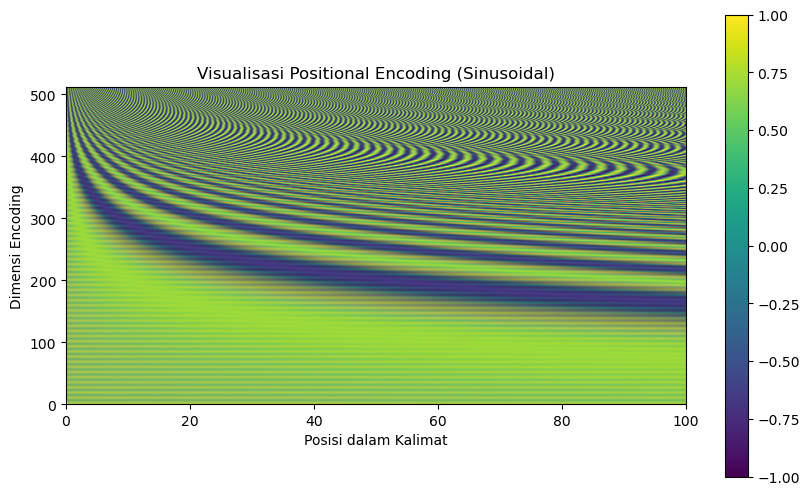

In [6]:
# Implementasi Positional Encoding
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 != 0: max_dims += 1 # max_dims harus genap
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, 0::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[1], :shape[2]]

# Visualisasi Positional Encoding
max_steps = 2048
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

plt.figure(figsize=(10, 6))
plt.imshow(PE.T, extent=(0, 100, 0, 512), aspect=0.1, cmap="viridis")
plt.title("Visualisasi Positional Encoding (Sinusoidal)")
plt.xlabel("Posisi dalam Kalimat")
plt.ylabel("Dimensi Encoding")
plt.colorbar()
plt.show()

### Multi-Head Attention (Implementasi Keras)

Komponen inti Transformer adalah **Multi-Head Attention**, di mana model memperhatikan berbagai bagian kalimat secara bersamaan dengan representasi yang berbeda (*heads*). Keras menyediakan layer `MultiHeadAttention` yang siap pakai.

In [7]:
# Contoh penggunaan layer MultiHeadAttention Keras
layer_mha = keras.layers.MultiHeadAttention(num_heads=2, key_dim=2)

# Input dummy (Batch, Sequence, Features)
target = tf.random.uniform((1, 2, 4)) 
source = tf.random.uniform((1, 2, 4))

# Self-Attention: query, key, dan value berasal dari sumber yang sama
output_tensor, weights = layer_mha(target, source, return_attention_scores=True)

print("Shape Output MHA:", output_tensor.shape)
print("Shape Weights:", weights.shape)

Shape Output MHA: (1, 2, 4)
Shape Weights: (1, 2, 2, 2)


## 5. Hugging Face Transformers (Pretrained Models)

### Teori
Melatih Transformer dari awal membutuhkan data masif dan komputasi mahal. Praktik modern memanfaatkan **Transfer Learning** menggunakan model yang sudah dilatih (*Pretrained Models*) seperti BERT, GPT-2, atau T5.

Library `transformers` dari Hugging Face menyediakan ribuan model siap pakai. API `pipeline` adalah cara termudah untuk menggunakannya.

In [8]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModelForCausalLM
import tensorflow as tf

# --- BAGIAN 1: Sentiment Analysis ---
print("=== 1. Sentiment Analysis ===")
model_name_sa = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer_sa = AutoTokenizer.from_pretrained(model_name_sa)

# PERBAIKAN: Tambahkan use_safetensors=False
model_sa = TFAutoModelForSequenceClassification.from_pretrained(
    model_name_sa, 
    use_safetensors=False
)

text = "The transformers library is incredibly easy to use and powerful!"
inputs = tokenizer_sa(text, return_tensors="tf")
logits = model_sa(inputs).logits
predicted_class_id = int(tf.argmax(logits, axis=-1)[0])
label = model_sa.config.id2label[predicted_class_id]

print(f"Text: {text}")
print(f"Hasil Sentimen: {label}")


# --- BAGIAN 2: Text Generation ---
print("\n=== 2. Text Generation ===")
model_name_gen = "gpt2"

tokenizer_gen = AutoTokenizer.from_pretrained(model_name_gen)

# PERBAIKAN: Tambahkan use_safetensors=False
model_gen = TFAutoModelForCausalLM.from_pretrained(
    model_name_gen, 
    use_safetensors=False
)

prompt = "Artificial Intelligence is changing the world because"
input_ids = tokenizer_gen.encode(prompt, return_tensors="tf")

generated_outputs = model_gen.generate(
    input_ids, 
    max_length=50, 
    num_return_sequences=1,
    pad_token_id=tokenizer_gen.eos_token_id,
    do_sample=True
)

generated_text = tokenizer_gen.decode(generated_outputs[0], skip_special_tokens=True)

print("Hasil Generasi Teks:")
print(generated_text)

=== 1. Sentiment Analysis ===




TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Text: The transformers library is incredibly easy to use and powerful!
Hasil Sentimen: POSITIVE

=== 2. Text Generation ===


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Hasil Generasi Teks:
Artificial Intelligence is changing the world because we need to be able to adapt them with the tools of science to overcome the difficulties that people have with humans. Today, when we learn that machines can learn, we know we will be able to apply a


### Kesimpulan Bab 16

1.  **Char-RNN** memungkinkan pembuatan teks yang kreatif tetapi sulit menangkap konteks panjang.
2.  **Encoder-Decoder** dengan **Attention** mengatasi *bottleneck* informasi pada penerjemahan bahasa.
3.  **Transformer** menggantikan RNN dengan mekanisme *Self-Attention* penuh dan *Positional Encoding*, memungkinkan paralelisasi pelatihan yang masif.
4.  **Hugging Face Transformers** mendemokratisasi akses ke model NLP canggih (SOTA) melalui API yang sederhana.